# VSR performance analysis

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Mixed seeds performance

We evaluate each evolved VSR using a distributed controller architecture.
In each voxel we place the controller evolved for the given morphology.
Most voxels, i.e., $(1-r)n$, $r$ being the rate and $n$ being the total number of voxels, are equipped with the controller evolved with a set random seed.
The remainder of voxels are equipped with controllers evolved with different random seeds.

We evaluate VSRs performance with:
- $v_x$: velocity along the $x$-axis (the larger the better)
- $\rho=\frac{v_{x,s} - v_x}{v_{x,s}}$: relative performance loss (the smaller the better). Here, $v_{x,s}$ is that achieved with all voxels having the same controller (i.e., resulting from the same seed).

In [32]:
cross_seed_df = pd.read_csv("mixed_seeds_validation.csv")
for target_set in cross_seed_df.target_set.unique():
  for shape_id in cross_seed_df.shape_id.unique():
    for seed in cross_seed_df.main_seed.unique():
      temp = cross_seed_df[
        (cross_seed_df.target_set == target_set) & (cross_seed_df.shape_id == shape_id)
        & (cross_seed_df.main_seed == seed)].copy().head(1)
      if len(temp) > 0:
        temp.vx = temp.baseline_vx
        temp.rate = 0
        cross_seed_df = pd.concat([cross_seed_df, temp], ignore_index=True)
cross_seed_df["relative_performance_loss"] = (cross_seed_df.baseline_vx - cross_seed_df.vx) / cross_seed_df.baseline_vx
cross_seed_df.head()

,target_set,shape_id,main_seed,readable_shape,baseline_vx,rate,rep,vx,seed_shape,relative_performance_loss
0,1,0,1,1111-1111-1001,3.266257,0.2,2.0,-0.028750,1111-4151-1xx1,1.008802
1,1,0,1,1111-1111-1001,3.266257,0.2,6.0,-0.020600,3111-1111-2xx1,1.006307
2,1,0,1,1111-1111-1001,3.266257,0.4,6.0,0.635768,5111-2312-1xx1,0.805353
3,1,0,1,1111-1111-1001,3.266257,0.3,6.0,0.004619,5111-4141-1xx1,0.998586
4,1,0,1,1111-1111-1001,3.266257,0.2,1.0,0.175104,1111-1114-3xx1,0.946390


In [33]:
median_cross_seed = cross_seed_df.groupby(["target_set", "main_seed", "shape_id", "rate"])[
  ["vx", "relative_performance_loss"]].median().reset_index()
median_cross_seed.head()

,target_set,main_seed,shape_id,rate,vx,relative_performance_loss
0,1,1,0,0.0,3.266257,0.000000
1,1,1,0,0.1,2.710327,0.170204
2,1,1,0,0.2,1.428503,0.562648
3,1,1,0,0.3,1.618159,0.504583
4,1,1,0,0.4,0.695271,0.787135


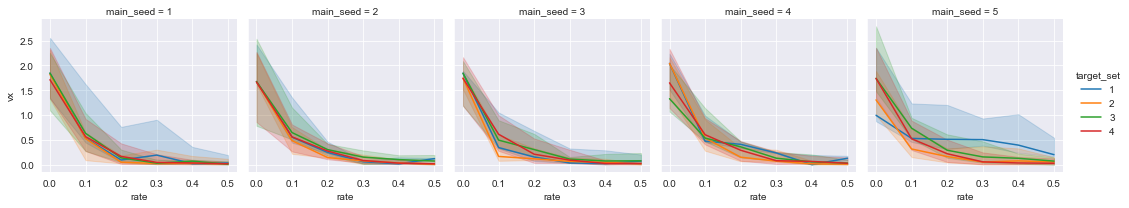

In [34]:
g = sns.FacetGrid(median_cross_seed, col="main_seed", hue="target_set")
g.map_dataframe(sns.lineplot, x="rate", y="vx", estimator="median", errorbar=("pi", 50))
g.add_legend()
plt.show()

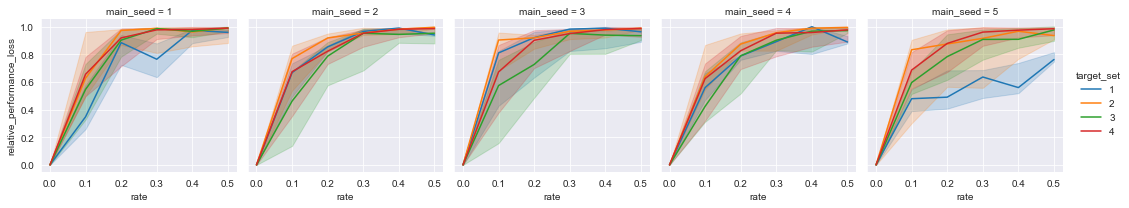

In [35]:
g = sns.FacetGrid(median_cross_seed, col="main_seed", hue="target_set")
g.map_dataframe(sns.lineplot, x="rate", y="relative_performance_loss", estimator="median", errorbar=("pi", 50))
g.add_legend()
plt.show()

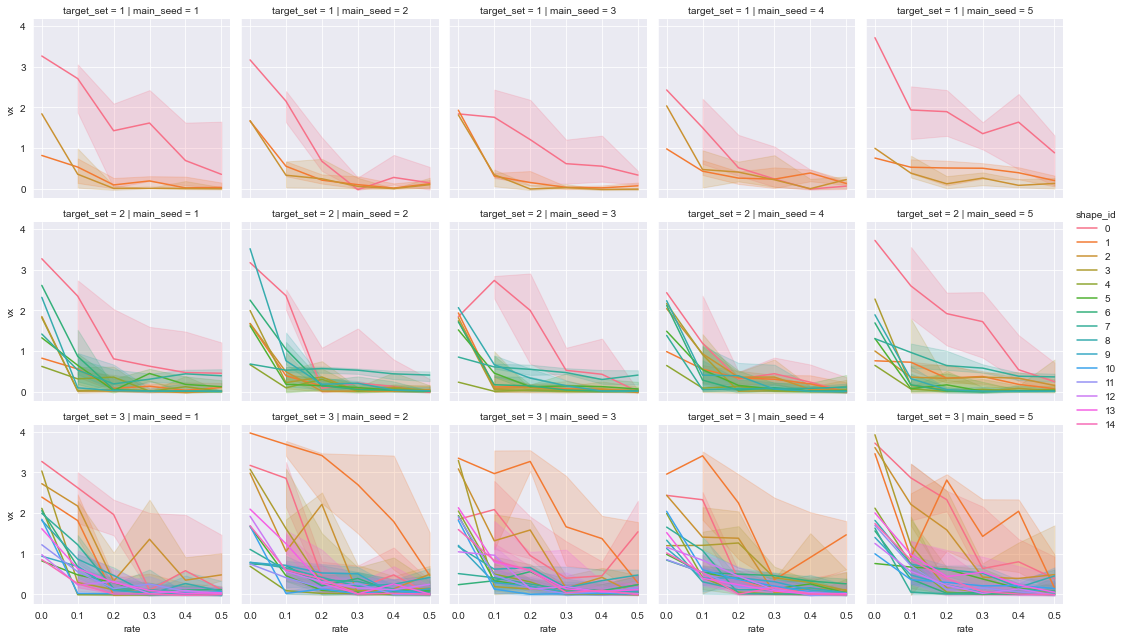

In [36]:
g = sns.FacetGrid(cross_seed_df[cross_seed_df.target_set != 4], row="target_set", col="main_seed", hue="shape_id")
g.map_dataframe(sns.lineplot, x="rate", y="vx", estimator="median", errorbar=("pi", 50))
g.add_legend()
plt.show()

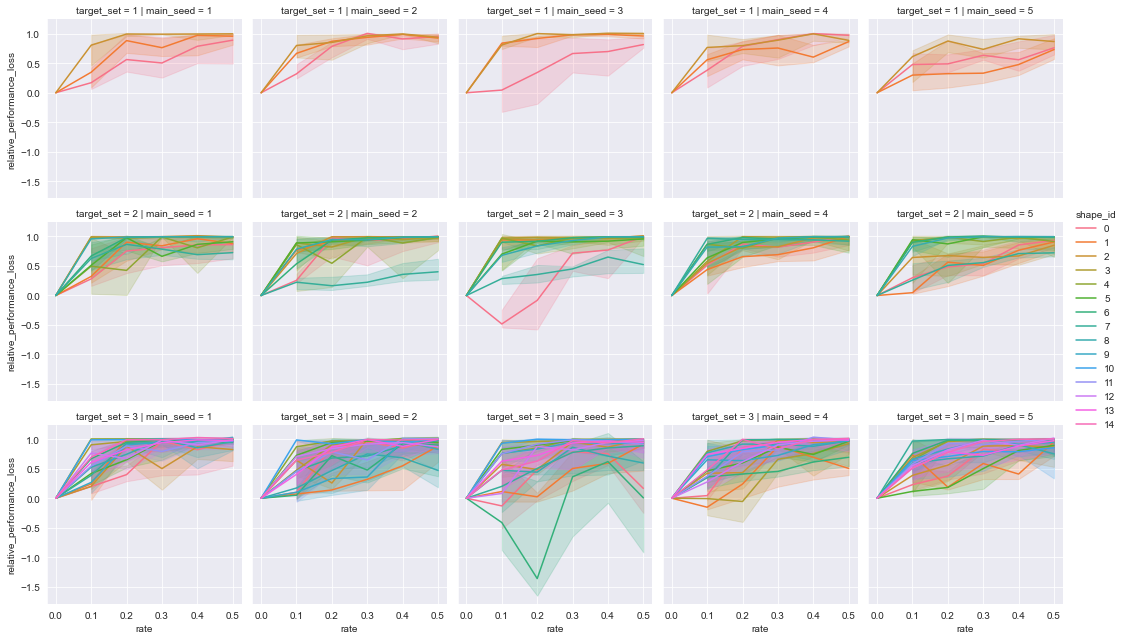

In [37]:
g = sns.FacetGrid(cross_seed_df[cross_seed_df.target_set != 4], row="target_set", col="main_seed", hue="shape_id")
g.map_dataframe(sns.lineplot, x="rate", y="relative_performance_loss", estimator="median", errorbar=("pi", 50))
g.add_legend()
plt.show()

## Performance in combination with the NCA classifier

We evaluate each evolved VSR using a distributed controller architecture.
To decide which controller to place in each voxel, we run a NCA classifier for $100$ total steps.
For each of these steps we equip each voxel with the controller evolved for the shape resulting from the classification.
In this case, we repeat the evaluation process with each of the $5$ seeds used for evolving controllers.

In addition, we also consider the outcome of majority voting at each time step, and equip all the voxels with the same controller, corresponding to the shape resulting from the voting.

As for the mixed seeds evaluation, we evaluate VSRs performance with:
- $v_x$: velocity along the $x$-axis (the larger the better)
- $\rho=\frac{v_{x,s} - v_x}{v_{x,s}}$: relative performance loss (the smaller the better), where $v_{x,s}$ is that achieved with all voxels having the correct controller for the given shape.

In [38]:
ground_truth_df = cross_seed_df.copy()
ground_truth_df = ground_truth_df[ground_truth_df["rate"] == 0]
ground_truth_df = ground_truth_df[["target_set", "shape_id", "vx", "main_seed"]]
ground_truth_df.rename(columns={"main_seed": "seed", "vx": "target_vx"}, inplace=True)
ground_truth_df.reset_index(inplace=True)
ground_truth_df.drop(columns=["index"], inplace=True)
ground_truth_df.head()

,target_set,shape_id,target_vx,seed
0,1,0,3.266257,1
1,1,0,3.170286,2
2,1,0,1.842849,3
3,1,0,2.431885,4
4,1,0,3.716926,5


In [39]:
class_df = pd.read_csv("larger_net_classification_velocities.csv")
class_df = pd.merge(class_df, ground_truth_df, how="left", on=["target_set", "shape_id", "seed"])
class_df_long = pd.melt(class_df.reset_index(),
                        id_vars=["target_set", "shape_id", "step", "accuracy", "majority_vote", "seed", "target_vx"],
                        value_vars=["classification_vx", "majority_vote_vx"])
class_df_long.rename(columns={"value": "vx"}, inplace=True)
class_df_long["relative_performance_loss"] = (class_df_long.target_vx - class_df_long.vx) / class_df_long.target_vx
class_df_long["variable"] = class_df_long["variable"].str.replace("_vx", "")
class_df_long.head()

,target_set,shape_id,step,accuracy,majority_vote,seed,target_vx,variable,vx,relative_performance_loss
0,1,0,0.0,0.2,2.0,1.0,3.266257,classification,-0.028513,1.008730
1,1,0,0.0,0.2,2.0,2.0,3.170286,classification,-0.029159,1.009197
2,1,0,0.0,0.2,2.0,3.0,1.842849,classification,0.055860,0.969688
3,1,0,0.0,0.2,2.0,4.0,2.431885,classification,0.163713,0.932681
4,1,0,0.0,0.2,2.0,5.0,3.716926,classification,-0.013689,1.003683


In [40]:
median_across_seeds = class_df_long.groupby(["target_set", "shape_id", "step", "variable"])[
  ["vx", "relative_performance_loss"]].median().reset_index()
median_across_seeds.head()

,target_set,shape_id,step,variable,vx,relative_performance_loss
0,1,0,0.0,classification,-0.013689,1.003683
1,1,0,0.0,majority_vote,0.308082,0.873316
2,1,0,1.0,classification,-0.014771,1.003974
3,1,0,1.0,majority_vote,3.170286,0.000000
4,1,0,2.0,classification,0.011837,0.993577


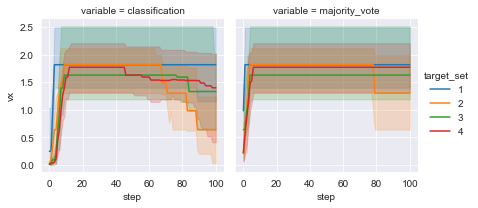

In [41]:
g = sns.FacetGrid(median_across_seeds, hue="target_set", col="variable")
g.map_dataframe(sns.lineplot, x="step", y="vx", estimator="median", errorbar=("pi", 50))
g.add_legend()
plt.show()

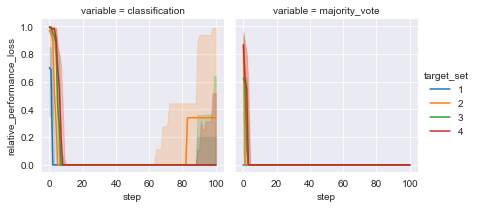

In [42]:
g = sns.FacetGrid(median_across_seeds, hue="target_set", col="variable")
g.map_dataframe(sns.lineplot, x="step", y="relative_performance_loss", estimator="median", errorbar=("pi", 50))
g.add_legend()
plt.show()

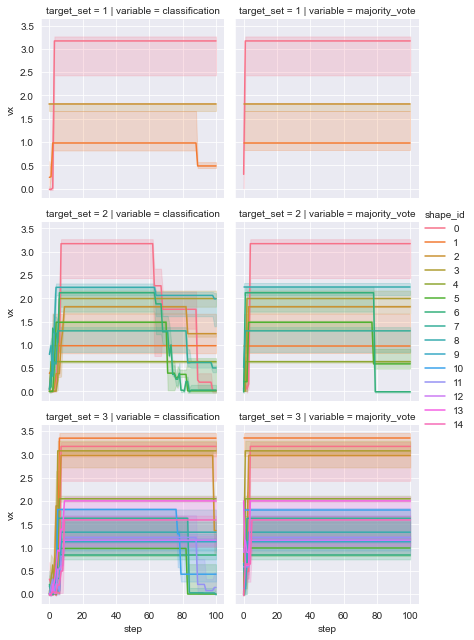

In [43]:
g = sns.FacetGrid(class_df_long[class_df_long.target_set != 4], row="target_set", col="variable", hue="shape_id")
g.map_dataframe(sns.lineplot, x="step", y="vx", estimator="median", errorbar=("pi", 50))
g.add_legend()
plt.show()

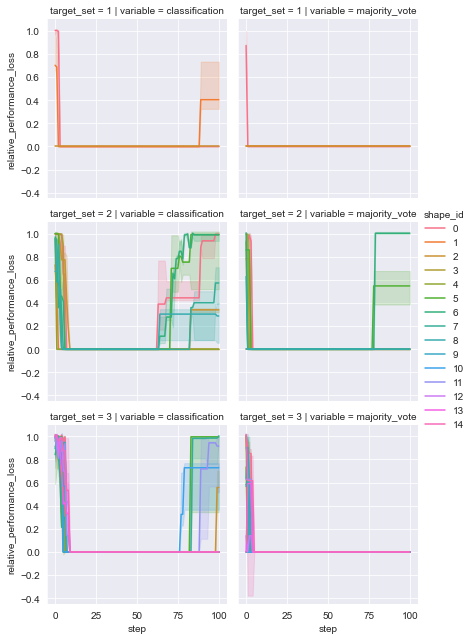

In [44]:
g = sns.FacetGrid(class_df_long[class_df_long.target_set != 4], row="target_set", col="variable", hue="shape_id")
g.map_dataframe(sns.lineplot, x="step", y="relative_performance_loss", estimator="median", errorbar=("pi", 50))
g.add_legend()
plt.show()

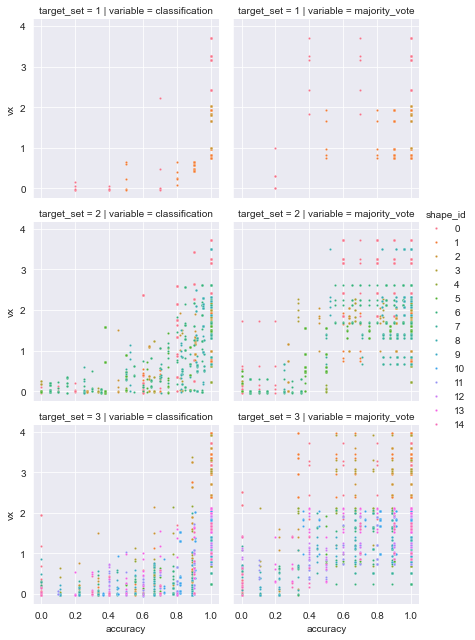

In [45]:
g = sns.FacetGrid(class_df_long[class_df_long.target_set != 4], row="target_set", col="variable", hue="shape_id")
g.map_dataframe(sns.scatterplot, x="accuracy", y="vx", s=5)
g.add_legend()
plt.show()

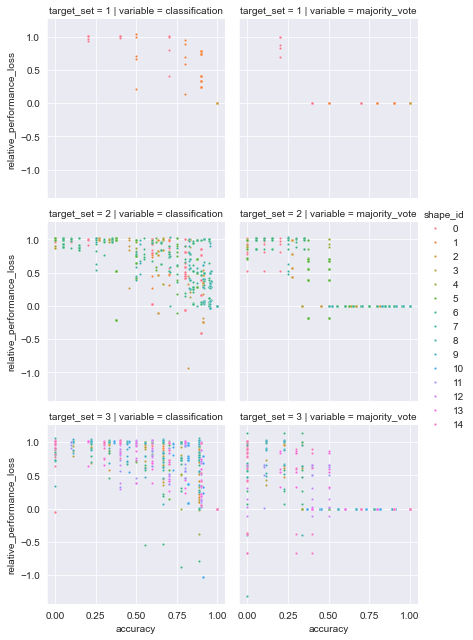

In [46]:
g = sns.FacetGrid(class_df_long[class_df_long.target_set != 4], row="target_set", col="variable", hue="shape_id")
g.map_dataframe(sns.scatterplot, x="accuracy", y="relative_performance_loss", s=5)
g.add_legend()
plt.show()

## Mismatched classification analysis
We evaluate the NCA trained on a smaller set applied on a larger set.
This can be considered as a proxy to evaluate the reactivity to unforeseen damages or assembly mistakes.

In [47]:
mismatch_class_df = pd.read_csv("larger_net_mismatched_classification_velocities.csv")
shapes = mismatch_class_df["readable_shape"].unique()
seeds = mismatch_class_df["seed"].unique()
dicts = []
for shape in shapes:
  for seed in seeds:
    tmp = mismatch_class_df[(mismatch_class_df["closest_shape_id"] == mismatch_class_df["majority_vote"])
                            & (mismatch_class_df["seed"] == seed)
                            & (mismatch_class_df["readable_shape"] == shape)]
    if len(tmp["majority_vote_vx"].unique()) > 0:
      dicts.append({
        "readable_shape": shape,
        "seed": seed,
        "closest_shape_vx": tmp["majority_vote_vx"].unique()[0]
      })
closest_shape_vxs_df = pd.DataFrame.from_dict(dicts)

In [48]:
ground_truth_df2 = ground_truth_df.rename(columns={"target_set": "shapes_set"}, inplace=False)
mismatch_class_df = pd.merge(mismatch_class_df, ground_truth_df2, how="left",
                             on=["shapes_set", "shape_id", "seed"])
mismatch_class_df = pd.merge(mismatch_class_df, closest_shape_vxs_df, how="left", on=["readable_shape", "seed"])
mismatch_class_df.head()

,shapes_set,shape_id,target_set,closest_shape_id,edit_distance,readable_shape,step,classification,majority_vote,seed,classification_vx,majority_vote_vx,target_vx,closest_shape_vx
0,3,0,1,0,0,1111-1111-1001,0,0;0;2-3;0;2-0;1;0-1;1;1-2;1;1-3;1;0-0;2;2-1;2;...,2,1,-0.028513,0.987258,3.266257,3.266257
1,3,0,1,0,0,1111-1111-1001,0,0;0;2-3;0;2-0;1;0-1;1;1-2;1;1-3;1;0-0;2;2-1;2;...,2,2,-0.029159,0.009391,3.170286,3.170286
2,3,0,1,0,0,1111-1111-1001,0,0;0;2-3;0;2-0;1;0-1;1;1-2;1;1-3;1;0-0;2;2-1;2;...,2,3,0.055860,0.316589,1.842849,1.842849
3,3,0,1,0,0,1111-1111-1001,0,0;0;2-3;0;2-0;1;0-1;1;1-2;1;1-3;1;0-0;2;2-1;2;...,2,4,0.163713,0.308082,2.431885,2.431885
4,3,0,1,0,0,1111-1111-1001,0,0;0;2-3;0;2-0;1;0-1;1;1-2;1;1-3;1;0-0;2;2-1;2;...,2,5,-0.013689,0.008928,3.716926,3.716926


In [49]:
mismatch_class_df_long = pd.melt(mismatch_class_df.reset_index(),
                                 id_vars=["target_set", "shapes_set", "closest_shape_id", "edit_distance", "shape_id",
                                          "step", "majority_vote", "seed", "target_vx"],
                                 value_vars=["classification_vx", "majority_vote_vx", "closest_shape_vx"])
mismatch_class_df_long.rename(columns={"value": "vx"}, inplace=True)
mismatch_class_df_long["relative_performance_loss"] = (
                                                          mismatch_class_df_long.target_vx - mismatch_class_df_long.vx) / mismatch_class_df_long.target_vx
mismatch_class_df_long["variable"] = mismatch_class_df_long["variable"].str.replace("_vx", "")
mismatch_class_df_long.head()

,target_set,shapes_set,closest_shape_id,edit_distance,shape_id,step,majority_vote,seed,target_vx,variable,vx,relative_performance_loss
0,1,3,0,0,0,0,2,1,3.266257,classification,-0.028513,1.008730
1,1,3,0,0,0,0,2,2,3.170286,classification,-0.029159,1.009197
2,1,3,0,0,0,0,2,3,1.842849,classification,0.055860,0.969688
3,1,3,0,0,0,0,2,4,2.431885,classification,0.163713,0.932681
4,1,3,0,0,0,0,2,5,3.716926,classification,-0.013689,1.003683


In [50]:
mismatch_median_across_seeds = mismatch_class_df_long.groupby(["target_set", "shapes_set", "shape_id", "edit_distance", "step",
                                "variable"])[["vx", "relative_performance_loss"]].median().reset_index()
mismatch_median_across_seeds["overlap"] = mismatch_median_across_seeds.edit_distance == 0
mismatch_median_across_seeds.head()

,target_set,shapes_set,shape_id,edit_distance,step,variable,vx,relative_performance_loss,overlap
0,1,3,0,0,0,classification,-0.013689,1.003683,True
1,1,3,0,0,0,closest_shape,3.170286,0.000000,True
2,1,3,0,0,0,majority_vote,0.308082,0.873316,True
3,1,3,0,0,1,classification,-0.014771,1.003974,True
4,1,3,0,0,1,closest_shape,3.170286,0.000000,True


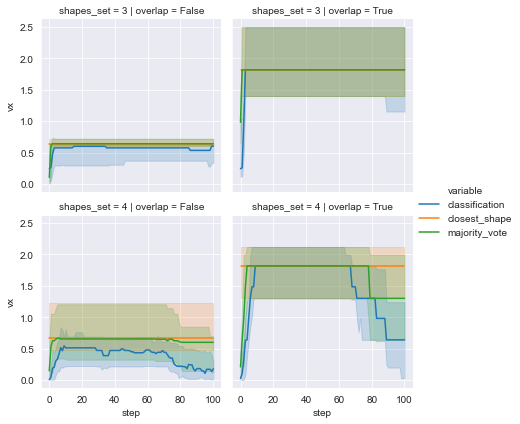

In [51]:
g = sns.FacetGrid(mismatch_median_across_seeds, col="overlap", row="shapes_set", hue="variable")
g.map_dataframe(sns.lineplot, x="step", y="vx", estimator="median", errorbar=("pi", 50))
g.add_legend()
plt.show()

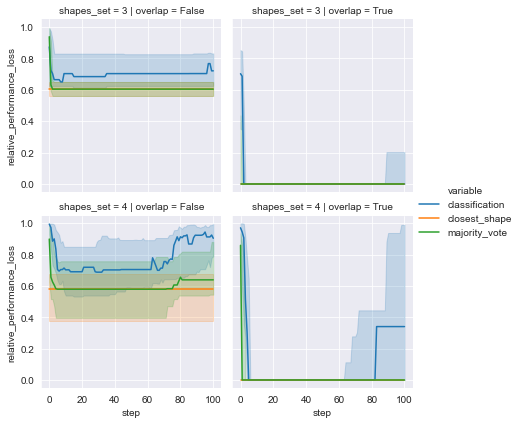

In [52]:
g = sns.FacetGrid(mismatch_median_across_seeds, col="overlap", row="shapes_set", hue="variable")
g.map_dataframe(sns.lineplot, x="step", y="relative_performance_loss", estimator="median", errorbar=("pi", 50))
g.add_legend()
plt.show()